In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#Adapted from: 
# lqr_neural_error_dynamics.ipynb

import scipy.io as sio
import scipy.stats as sio_stat
import scipy.interpolate
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt 

import os
import pickle
import sys
import copy

import time
import pylab as pl
from IPython import display

from bmi_dynamics_code import behavior_co_obs as bmi_b
from bmi_dynamics_code import data_for_v as preeyacode
from bmi_dynamics_code import util as bmi_util

import timeit
from sklearn import decomposition as skl_decomp

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

%matplotlib notebook

In [3]:
%matplotlib notebook

In [4]:
# data_dir = '/Users/vivekathalye/Dropbox/Code/preeya_co_obstacle'
save_dir = r'D:\Dropbox\BMI_co_obs_paper\data\vivek\lqr'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
ext_list =['.png', '.eps']

home_dir = r'D:\Dropbox\Code\preeya_co_obstacle'
data_dir = r'D:\Dropbox\Data\preeya_co_obstacle'
data_path = os.path.join(data_dir, 'for_v_df.pkl')
print(os.path.exists(data_path))
d = pickle.load(open(data_path))

#UNPACK: 
decoder = d['decoder']
pre = d['pre']
num_targets = d['num_targets']
sample_period = d['sample_period']
target_hold_time = d['target_hold_time']
num_neurons = d['num_neurons']
target_color = d['target_color']
obs_big = d['obs_big']
obs_small = d['obs_small']
target_r_task = d['target_r_task'] #target_r_task = {0:1.7, 1:2.0}
cursor_r = d['cursor_r']
target_r_eff = d['target_r_eff']
target_pos = d['target_pos']
target_angle = np.arctan2(target_pos[:,1], target_pos[:,0])
target_dist = np.linalg.norm(target_pos, axis=1)
obs_pos = d['obs_pos']

tc_meta = d['tc_meta']
task_list = d['task_list']
num_tasks = len(task_list)
task2idx = d['task2idx']
idx2task = bmi_util.invert_dic(task2idx)
task2tc = d['task2tc']
tc_list = d['tc_list']
df = d['df']
df_label = d['df_label']

task_color = ['k', 'r']

#Pre-processing: 

bmi_b.preprocess_bmi_df(df, target_pos, pre, num_tasks, num_targets)
num_cw = 2
cw_label = ['cw', 'ccw']
task_rot_list = [0,1.1,1.2]

#Binning: 
#MAGNITUDE:
num_mag_bins = 5
num_mag_bins_analyze = 4
# mag_bin_perc = np.array([0,25,50,75,100])
mag_bin_perc = np.concatenate([np.linspace(0,95,5),np.array([100])])
#ANGLE:
num_angle_bins = 8
T0_angle = -3*(2*np.pi)/8
mag_bin, mag_bin_edges, mag_bin_c, angle_bin_c, angle_bin, angle_bin_edges =\
bmi_b.def_command_bin(df, mag_bin_perc, num_angle_bins, T0_angle)
#CENTER ANGLE DATA FOR BINNING (based on bin boundaries): 
angle_center_for_binning = bmi_b.df_center_angle_for_binning(df, angle_bin)
#BIN: 
bmi_b.df_bin_command(df, mag_bin_edges,angle_bin_edges)

#Pre-processing continued:

#Center angles to command bin, target: 
bmi_b.center_df_angle(df, angle_bin_c, target_angle)

True
('angle_center:', 22.5)
('min centered angle:', -157.47162455426732)
('max centered angle:', 202.46708261619673)


<IPython.core.display.Javascript object>


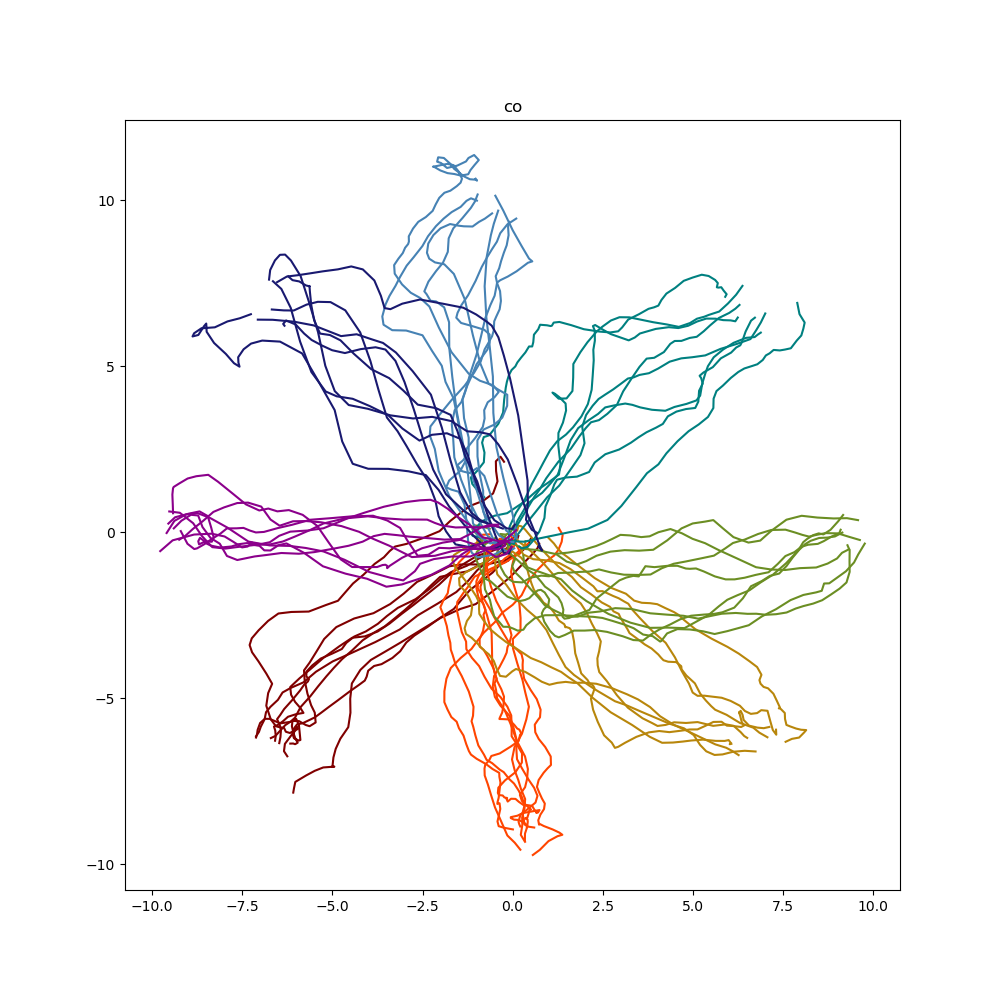

<IPython.core.display.Javascript object>


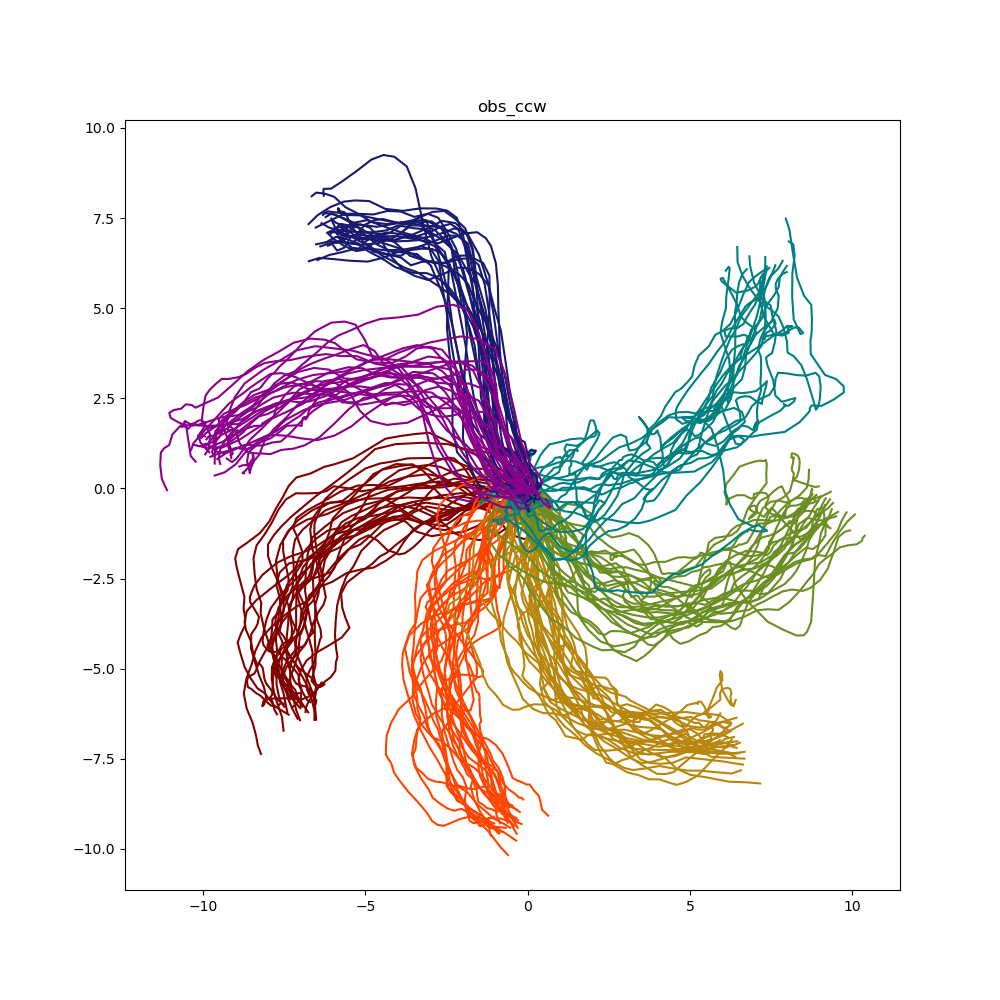

<IPython.core.display.Javascript object>


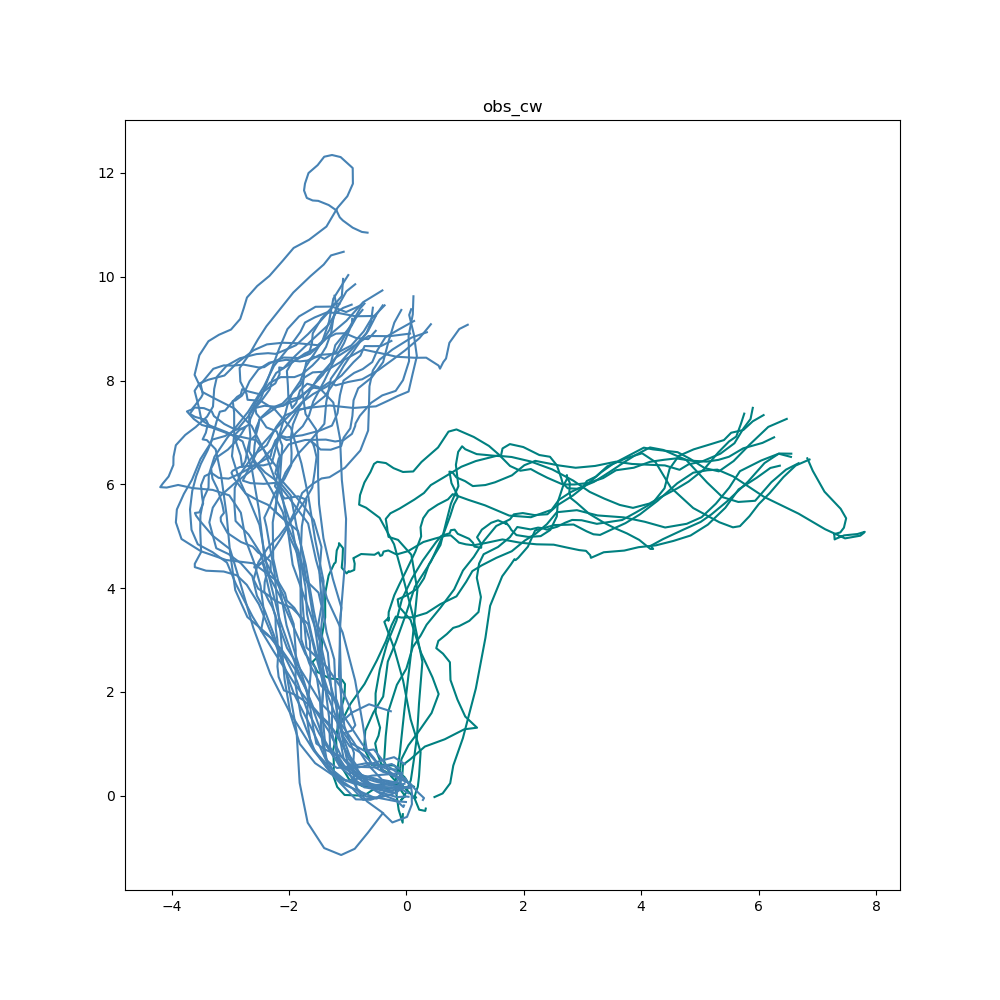

In [5]:
#Plot cw vs ccw trials, to confirm: 
plot = {}
plot['size'] = (10,10)
plot['xlim'] = (-12.5,12.5)
plot['ylim'] = (-12.5,12.5)
task_rot_list = [0,1.1,1.2]
task_rot_label = ['co','obs_ccw', 'obs_cw']

for i,task in enumerate(task_rot_list):
    plt.figure(figsize=plot['size'])
    plt.title(task_rot_label[i])
    for target in range(num_targets):    
            sel = (df['task_rot']==task) & (df['bin']>=0) & (df['target']==target)
            df_sel = df[sel]
            #------------------------------------------------------------------------------------
            #TRIALS: 
            trial_start = np.where(df_sel['bin']==0)[0]
            trial_stop = np.where(df_sel['bin_end']==0)[0]
            trial_bound = np.vstack((trial_start,trial_stop)).T
            #------------------------------------------------------------------------------------
            for bnd in trial_bound[:,:]: #trial_bound[0:1,:]:
    #             if (task_str == 'co') or (task_str == 'obs') and (df_sel['obs_size'][bnd[0]:bnd[0]+1] == obs_big).bool(): 
                x = df_sel['kin_px'][bnd[0]:bnd[1]+1]
                y = df_sel['kin_py'][bnd[0]:bnd[1]+1]
                color = target_color[target]
                plt.plot(x,y,'-',color=color)

4704     115.0
4755     116.0
4796     117.0
4842     118.0
4890     119.0
4941     120.0
4988     121.0
5046     122.0
5122     123.0
5392     127.0
10206    238.0
Name: trial_global, dtype: float64


<IPython.core.display.Javascript object>


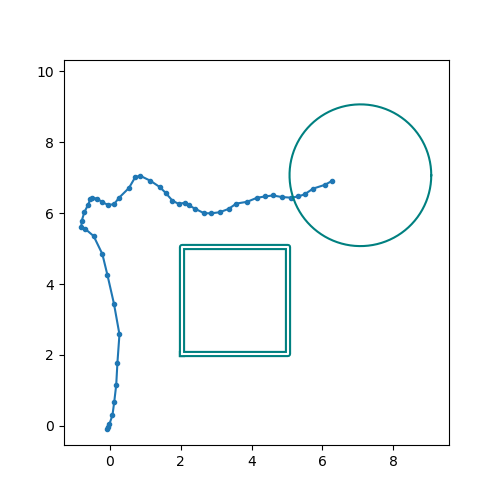

(-1.3012247717787875,
 9.564986506324725,
 -0.5427594616898825,
 10.32345181641363)

In [6]:
target = 4
sel_target = (df['target']==target)
sel_start = (df['bin']==0)
sel_task = (df['task_rot']==1.2) #1.2 is clockwise, 1.1 is counterclockwise
sel = sel_target&sel_start&sel_task
trials = df.loc[sel,'trial_global']
print(trials)

trial = int(trials.iloc[0])
sel_trial = (df['trial_global']==trial)
sel_bin = (df['bin']>=0)
sel = sel_trial&sel_bin

x = df.loc[sel, 'kin_px']
y = df.loc[sel, 'kin_py']

plt.figure(figsize=(5,5))
plt.plot(x,y, '.-')
c = target_color[target]
bmi_util.plot_obstacles(obs_pos[target,:].reshape((1,-1)), [c], obs_big*np.ones(1))
bmi_util.plot_targets(target_pos[target,:].reshape((1,-1)), [c], target_r_task[1]*np.ones(1))
plt.axis('square')

### Load noiseless lqr 

In [7]:
save_path = os.path.join(save_dir, 'lqr_noiseless.pkl')
with open(save_path, 'rb') as f: 
    r = pickle.load(f)
#Note the simulations were run with neural activity initialized to 0    
for (k,v) in r.items():
    exec(k+'=v')
    
n_list = ['n_'+ str(i) for i in np.arange(num_neurons)]

In [8]:
r.keys()

['Qv_s',
 'num_targets',
 'num_mag_bins_analyze',
 'A_dic',
 'angle_bin_edges',
 'input_label',
 'obs_margin',
 'Qfp_s',
 'Q_f',
 'mag_bin',
 'angle_bin',
 'state_label',
 'df_mean',
 'mag_bin_c',
 'kin_var',
 'df_diff',
 'Qfv_s',
 'model_list',
 'n_init',
 'df_lqr',
 'B',
 'task_rot_list',
 'F',
 'bn',
 'R_s',
 'Kn',
 'Q',
 'R',
 'mag_bin_edges',
 'df_norm_lqr',
 'offset_var',
 'angle_bin_c',
 'waypoint_speed',
 'A_list',
 'angle_center_for_binning',
 'center',
 'move_lqr',
 'An',
 'Qp_s',
 'move_horizon']

### Fit regression to different models

### Dynamics model, use A

In [9]:
m = 'n_do'

sel_m = (df_lqr['model']==m)

sel_t_bin = (df_lqr['bin'] >= 0)
sel_t_bin_end = (df_lqr['bin_end'] >= 1)
sel_t = (sel_t_bin)&(sel_t_bin_end)&sel_m
n_t = np.array(df_lqr.loc[sel_t,n_list]).T

sel_tp1_bin = (df_lqr['bin'] >= 1)
sel_tp1_bin_end = (df_lqr['bin_end'] >= 0)
sel_tp1 = (sel_tp1_bin)&(sel_tp1_bin_end)&sel_m
n_tp1 = np.array(df_lqr.loc[sel_tp1,n_list]).T

nhat_tp1 = np.dot(An, n_t)+ bn.reshape((-1,1))


#sanity check we can use the dynamics parameters:
total_cov = np.cov(n_tp1)
total_var = np.trace(total_cov)

res_hat = nhat_tp1-n_tp1 #44 x num_obs
res_cov = np.cov(res_hat) #44 x 44
res_var = np.trace(res_cov)

pred_cov = np.cov(nhat_tp1)
pred_var = np.trace(pred_cov)

print('sanity check on neural dynamics fit:')
print('model A R2: ', 1-res_var/total_var)
# print('true R2: ', clf.score(n_t, n_tp1))

sanity check on neural dynamics fit:
('model A R2: ', 0.8836633403341088)


<IPython.core.display.Javascript object>


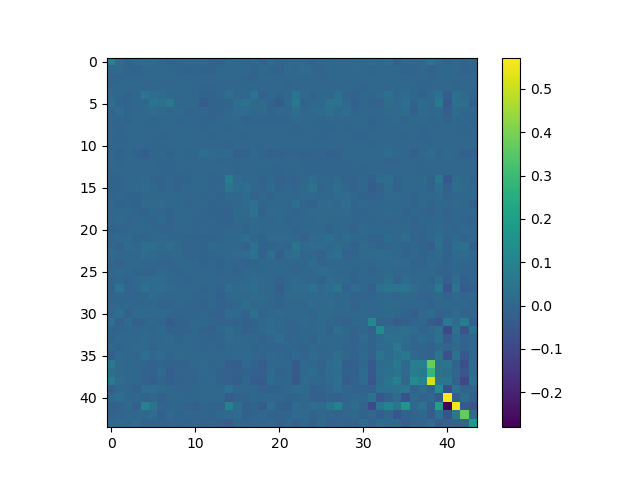

In [10]:
plt.figure()
plt.imshow(An)
plt.colorbar()

### Dynamics model, fit new A, b

In [12]:
m = 'n_do'

sel_m = (df_lqr['model']==m)

sel_t_bin = (df_lqr['bin'] >= 0)
sel_t_bin_end = (df_lqr['bin_end'] >= 1)
sel_t = (sel_t_bin)&(sel_t_bin_end)&sel_m
n_t = np.array(df_lqr.loc[sel_t,n_list]).T

sel_tp1_bin = (df_lqr['bin'] >= 1)
sel_tp1_bin_end = (df_lqr['bin_end'] >= 0)
sel_tp1 = (sel_tp1_bin)&(sel_tp1_bin_end)&sel_m
n_tp1 = np.array(df_lqr.loc[sel_tp1,n_list]).T


# regression: 
#ridge parameter from Preeya: 2500
clf = Ridge(alpha=1)
clf.fit(n_t.T, n_tp1.T)

An_fit = clf.coef_
bn_fit = clf.intercept_

print('fit A R2: ', clf.score(n_t.T, n_tp1.T))

('fit A R2: ', 0.986268332601159)


<IPython.core.display.Javascript object>


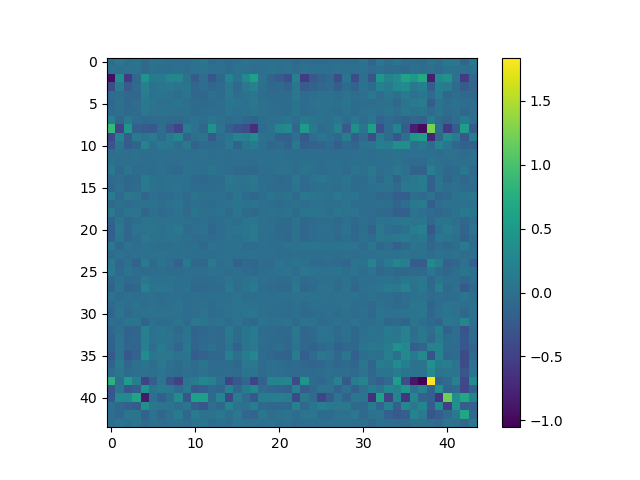

In [13]:
plt.figure()
plt.imshow(An_fit)
plt.colorbar()

### No dynamics model, fit new A, b

In [14]:
m = 'n_null'

sel_m = (df_lqr['model']==m)

sel_t_bin = (df_lqr['bin'] >= 0)
sel_t_bin_end = (df_lqr['bin_end'] >= 1)
sel_t = (sel_t_bin)&(sel_t_bin_end)&sel_m
n_t = np.array(df_lqr.loc[sel_t,n_list]).T

sel_tp1_bin = (df_lqr['bin'] >= 1)
sel_tp1_bin_end = (df_lqr['bin_end'] >= 0)
sel_tp1 = (sel_tp1_bin)&(sel_tp1_bin_end)&sel_m
n_tp1 = np.array(df_lqr.loc[sel_tp1,n_list]).T

clf = Ridge(alpha=1)
clf.fit(np.array(n_t).T, np.array(n_tp1).T)

An_fit_null = clf.coef_
bn_fit_null = clf.intercept_

print('fit A R2: ', clf.score(n_t.T, n_tp1.T))

('fit A R2: ', 0.65499554368196)


<IPython.core.display.Javascript object>


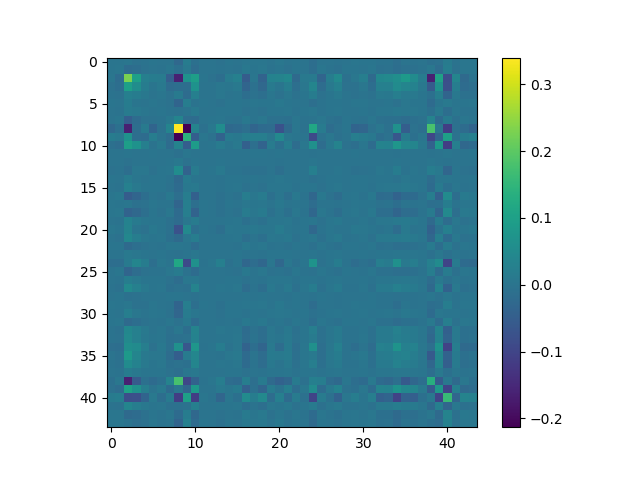

In [15]:
plt.figure()
plt.imshow(An_fit_null)
plt.colorbar()

### Load  lqr sim data

In [16]:
save_path = os.path.join(save_dir, 'lqr_noiseless.pkl')
with open(save_path, 'rb') as f: 
    r = pickle.load(f)
#Note the simulations were run with neural activity initialized to 0    
for (k,v) in r.items():
    exec(k+'=v')

<IPython.core.display.Javascript object>


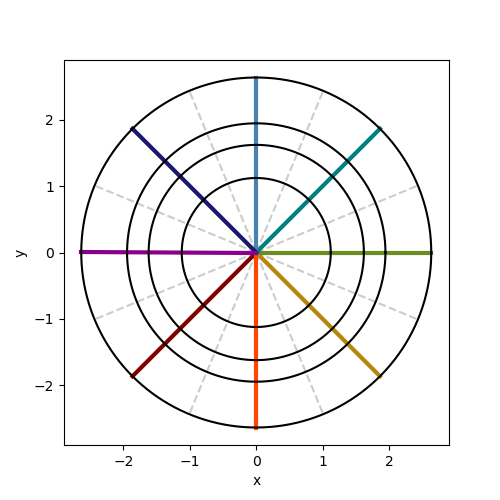

In [17]:
num_mag_bins_analyze=4
def plot_command_bin(): 
    bmi_b.plot_polar_bins(angle_bin_edges, mag_bin_edges[:,:(num_mag_bins_analyze)], target_color)
    
plt.figure(figsize=(5,5))
plot_command_bin()    

<IPython.core.display.Javascript object>


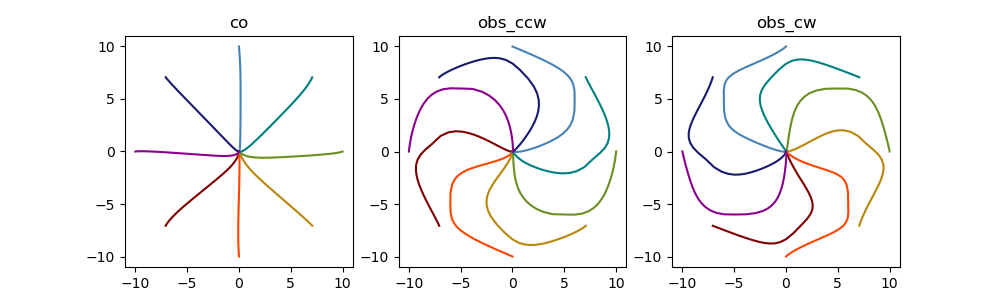

In [18]:
#Plot cw vs ccw trials, to confirm: 
m = 'n_do'
plot = {}
plot['size'] = (10,3)
plot['xlim'] = (-12.5,12.5)
plot['ylim'] = (-12.5,12.5)
task_rot_list = [0,1.1,1.2]
task_rot_label = ['co','obs_ccw', 'obs_cw']


num_trials_plot = 10
plt.figure(figsize=plot['size'])
for i,task in enumerate(task_rot_list): 
    plt.subplot(1,3,i+1)
    plt.title(task_rot_label[i])    
    for target in range(num_targets):    
        sel = (df_lqr['task_rot']==task) & (df_lqr['bin']>=0) & (df_lqr['target']==target) & (df_lqr['model'] == m)
        df_sel = df_lqr[sel]
        #------------------------------------------------------------------------------------
        #TRIALS: 
        trial_start = np.where(df_sel['bin']==0)[0]
        trial_stop = np.where(df_sel['bin_end']==0)[0]
        trial_bound = np.vstack((trial_start,trial_stop)).T
        #------------------------------------------------------------------------------------
        for bnd in trial_bound[:num_trials_plot,:]: #trial_bound[0:1,:]:
#             if (task_str == 'co') or (task_str == 'obs') and (df_sel['obs_size'][bnd[0]:bnd[0]+1] == obs_big).bool(): 
            x = df_sel['kin_px'][bnd[0]:bnd[1]+1]
            y = df_sel['kin_py'][bnd[0]:bnd[1]+1]
            color = target_color[target]
            plt.plot(x,y,'-',color=color)

### Analyze diff command-movement vs command

In [19]:
df_mean.head()

,n_0,n_1,n_2,n_3,n_4,n_5,n_6,n_7,n_8,n_9,...,n_38,n_39,n_40,n_41,n_42,n_43,ba,bm,model,num
0,1.263037,0.465240,0.216860,0.102383,1.231103,2.334915,1.397706,0.221250,-0.169530,0.103973,...,3.307842,1.228667,1.515020,3.051798,0.803016,1.210370,0,0,n_do,16
1,0.682726,0.320595,0.212005,0.152062,0.738963,1.766962,1.019651,0.211041,0.059290,-0.068717,...,1.209648,0.931440,0.762813,1.023033,0.455222,1.103445,0,0,n_o,8
2,0.001427,-0.032741,0.395054,0.181476,0.049075,0.027528,0.031823,-0.077750,-0.241706,0.086958,...,-0.269410,0.199246,-0.170536,0.071245,-0.044186,-0.012621,0,0,n_null,8
3,1.169901,0.455201,0.295449,0.122024,1.337876,2.457800,1.460253,0.229515,-0.250830,0.151751,...,2.329294,1.473334,0.709250,3.898307,1.005178,1.155887,0,1,n_do,40
4,0.678844,0.288860,0.541985,0.315927,0.787072,1.785438,1.048063,0.146967,-0.094744,-0.031463,...,0.998245,1.115710,0.583770,1.087042,0.410898,1.084807,0,1,n_o,36


In [20]:
#mean diff: 
df_diff_col = n_list + ['diff', 'diff_null', 'diff_potent', 'ba', 'bm', 'model', 'target', 'task_rot', 'num']
nan_df = pd.DataFrame()
df_diff = []
for ba in range(num_angle_bins):
    sel_ba = (df_lqr['u_v_angle_bin']==ba)
    sel_d_ba = (df_mean['ba'] == ba)    
    for bm in range(num_mag_bins_analyze):
        sel_bm = (df_lqr['u_v_mag_bin']==bm)
        sel_d_bm = (df_mean['bm'] == bm)
        for m in model_list:
            sel_m = (df_lqr['model'] == m)
            sel_d_m = (df_mean['model'] == m)
            sel_d = sel_d_ba&sel_d_bm&sel_d_m
            mean_i = df_mean.loc[sel_d, n_list]
            
            
            for task in task_rot_list:
                sel_task = (df_lqr['task_rot']==task)
                for target in range(num_targets):
                    sel_target = (df_lqr['target']==target)
                    
                    sel = sel_ba&sel_bm&sel_m&sel_task&sel_target
                    num = len(np.where(sel)[0])
                    if num > 0:
                        n_i = df_lqr.loc[sel,n_list].mean()
                        diff_i = n_i-mean_i
                        diff_potent_i, diff_null_i, _ = bmi_util.proj_null_potent(Kn[2:4,:].T, np.array(diff_i).reshape((-1,1)))
                        
                        df_i = pd.DataFrame(pd.DataFrame(np.ones((1,len(df_diff_col)))*np.nan, columns=df_diff_col))
                        df_i.loc[0,n_list]=n_i
                        df_i['diff']=np.linalg.norm(diff_i)
                        df_i['diff_null']=np.linalg.norm(diff_null_i)
                        df_i['diff_potent']=np.linalg.norm(diff_potent_i)
                        df_i['ba'] = ba
                        df_i['bm'] = bm
                        df_i['model'] = m
                        df_i['task_rot'] = task
                        df_i['target'] = target
                        df_i['num'] = num

                        df_diff.append(df_i)
df_diff = pd.concat(df_diff, ignore_index=True)   

<IPython.core.display.Javascript object>


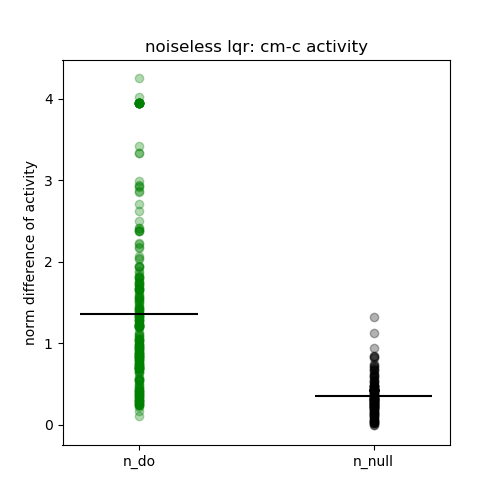

n_do
n_null


Text(0,0.5,'norm difference of activity')

In [22]:
plt.figure(figsize=(5,5))

model_list = ['n_do', 'n_null']
model_color = {'n_do':'g', 'n_o':'r', 'n_null':'k'}
d_cm_diff = []


min_obs = 1
for i,m in enumerate(model_list):
    print(m)
    sel_m = df_diff['model']==m
    sel_obs = df_diff['num']>=min_obs
    
    sel = sel_m&sel_obs
#     sel = sel_m&sel_obs
    diff_i = df_diff.loc[sel, 'diff']
    d_cm_diff.append(diff_i)
    diff_mean_i = df_diff.loc[sel, 'diff'].mean()
#     num = df_diff.loc[sel, 'num'].mean()
#     print(m, test, num)
    plt.scatter(i*np.ones(len(diff_i)), diff_i, alpha=0.3,color=model_color[m])
    plt.hlines(diff_mean_i, i-0.25,i+0.25)
    
_=plt.xticks([0,1], model_list)
plt.title('noiseless lqr: cm-c activity')
plt.ylabel('norm difference of activity')
    

<IPython.core.display.Javascript object>


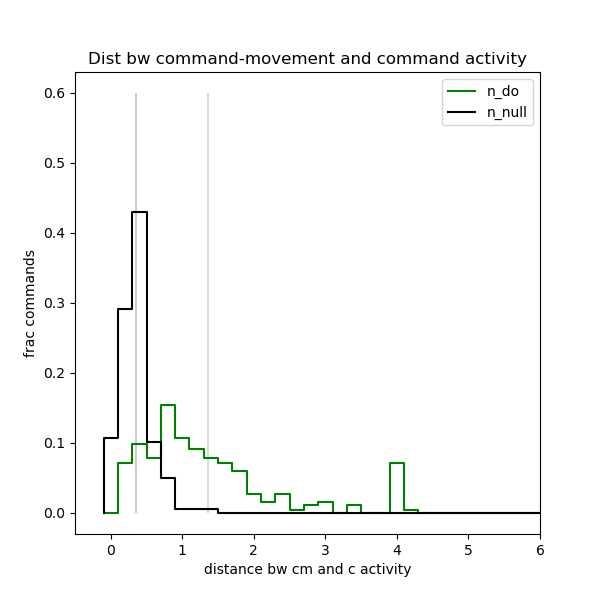

36
(74L,)
36
(74L,)


Text(0.5,1,'Dist bw command-movement and command activity')

In [23]:
#Histogram the diffs and plot overlapping distributions:
vmin = 0
vmax = 7
num_bins = (vmax-vmin)*5+1
cm_diff_bins_c = np.linspace(0,7,num_bins)
bin_w = cm_diff_bins_c[1]-cm_diff_bins_c[0]
cm_diff_bins_e = np.vstack((cm_diff_bins_c-bin_w/2, cm_diff_bins_c+bin_w/2))
bin_dic = {0:cm_diff_bins_e}

cm_diff_binned = []
for i,d in enumerate(d_cm_diff):
    d = np.array(d).reshape((-1,1))
    bin_result, hist_result = bmi_b.bin_vec_data(d,bin_dic)
    cm_diff_binned.append(hist_result)


model_color = {'n_do':'g', 'n_o':'r', 'n_null':'k'}    
cm_diff_bins_e_flat = np.hstack((cm_diff_bins_e[0,:], cm_diff_bins_e[1,-1]))

plt.figure(figsize=(6,6))
for i,d in enumerate(cm_diff_binned):
    m = model_list[i]
    d_plot = d/np.sum(d)
#     d_plot = np.cumsum(d_plot)
    bmi_util.hist_step_plot(cm_diff_bins_e_flat, d_plot,color=model_color[m],label=m)
    
    d_mean = np.mean(d_cm_diff[i])
    plt.vlines(d_mean, 0, 0.6, color=model_color[m],alpha=0.2)
plt.xlim((-0.5,6))    
plt.legend()    
plt.xlabel('distance bw cm and c activity')
plt.ylabel('frac commands')
plt.title('Dist bw command-movement and command activity')


### Add posthoc noise 

In [206]:
#Reload noiseless
save_path = os.path.join(save_dir, 'lqr_noiseless.pkl')
with open(save_path, 'rb') as f: 
    r = pickle.load(f)
#Note the simulations were run with neural activity initialized to 0    
for (k,v) in r.items():
    exec(k+'=v')

<IPython.core.display.Javascript object>


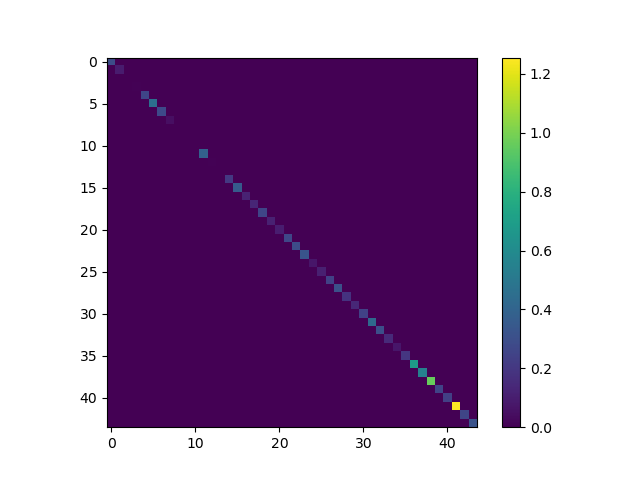

<IPython.core.display.Javascript object>


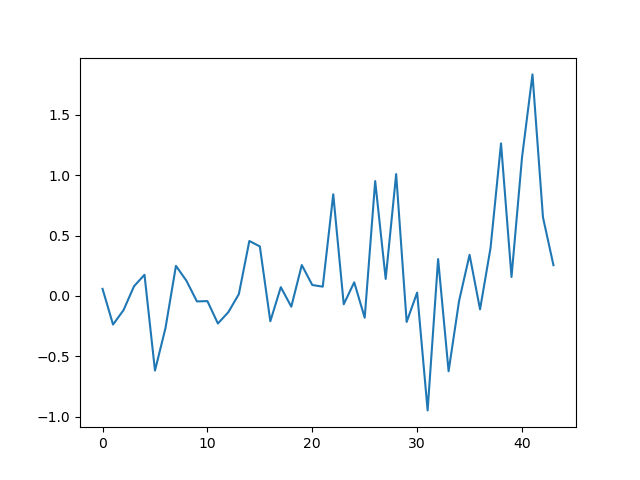

In [207]:
### Add noise to the above: 

#Compute noise to add: 

sel_t_bin = (df['bin'] >= 0)
sel_t_bin_end = (df['bin_end'] >= 1)
sel_t = (sel_t_bin)&(sel_t_bin_end)
n_t = df.loc[sel_t,n_list]

sel_tp1_bin = (df['bin'] >= 1)
sel_tp1_bin_end = (df['bin_end'] >= 0)
sel_tp1 = (sel_tp1_bin)&(sel_tp1_bin_end)
n_tp1 = df.loc[sel_tp1,n_list]

n_t_m = np.mat(n_t).T
n_tp1_m = np.mat(n_tp1).T
An_m = np.mat(An)
bn_m = np.mat(bn).T
nhat_tp1 = An_m*n_t_m+bn_m

res_hat = nhat_tp1-n_tp1_m #44 x num_obs
res_cov = np.cov(res_hat) #44 x 44
res_cov_d = np.diag(np.diag(res_cov))

#----------------------------------------------------------------------------------------------
#Zero out the noise in the potent dimensions of the decoder: 
# res_cov_d_NULL = res_cov_d-np.dot(np.dot(P,res_cov_d), P.T)
Kn2v = Kn[2:4,:]
u,s,vh = np.linalg.svd(Kn2v)
vh_trunc = vh[:2,:]
P = np.dot(vh_trunc.T,vh_trunc)
# P.shape
# np.linalg.matrix_rank(P)
# test = np.dot(u, np.dot(np.diag(s), vh_trunc))

P_null = np.eye(num_neurons)-P
res_cov_d_NULL = np.dot(np.dot(P_null,res_cov_d), P_null.T)
#----------------------------------------------------------------------------------------------

state_noise_mean = np.zeros(num_neurons)
state_noise_cov =  res_cov_d/5 #res_cov_d_NULL
state_noise = np.random.multivariate_normal(mean=state_noise_mean, cov=state_noise_cov)

plt.figure()
plt.imshow(state_noise_cov)
plt.colorbar()

plt.figure()
plt.plot(state_noise)

# #simulate with noise: 
# #Define a noise covariance, and let's just simulate one trial to start with:
# state_dim = num_neurons+len(kin_var)+len(offset_var)
# state_noise_mean = np.zeros(state_dim)
# state_noise_cov = np.zeros((state_dim, state_dim)) #np.eye(state_dim)*0.5
# state_noise_cov[:num_neurons,:num_neurons] = res_cov_d
# state_noise_cov[num_neurons:, num_neurons:] = 0

# plt.figure(figsize=(5,5))
# plt.imshow(state_noise_cov)

# #Test noise generation:
# state_noise = np.random.multivariate_normal(mean=state_noise_mean, cov=state_noise_cov)
# state_noise.shape
# state_noise

# # plt.figure()
# # plt.plot(state_noise, '.-')

# plt.figure()
# plt.plot(np.diag(res_cov_d))

In [208]:
#Loop over number of noise iterations: 
N_noisy = 20

u_var = ['u_px','u_py','u_vx','u_vy','u_offset']
extract_col = n_list+kin_var+u_var+\
['task_rot', 'target', 'bin', 'bin_end', 'trial', 'model']

df_noise_list = []
for i in range(N_noisy):
    df_lqr_noise = copy.copy(df_lqr.loc[:, extract_col])
    #Add noise to neural activity
    noise = np.random.multivariate_normal(mean=state_noise_mean, cov=state_noise_cov, size=(df_lqr_noise.shape[0]))
    n = np.array(df_lqr_noise.loc[:,n_list])
    df_lqr_noise.loc[:,n_list] = n+noise    
    
    #Multiply neural activity by decoder: 
    n_mat= np.array(df_lqr_noise.loc[:, n_list]).T #num_neurons X num_samples
    u_mat= np.dot(Kn, n_mat)
    u_mat.shape    
    
    #Update columns of df_lqr_noise: 
    df_lqr_noise.loc[:,u_var] = u_mat.T    
    
    #Append: 
    df_noise_list.append(df_lqr_noise)

df_lqr_noise = pd.concat(df_noise_list, ignore_index=True)

In [142]:
# for i in df_lqr_noise.columns:
#     print(i)
    
# for i in df_lqr.columns:
#     print(i)

In [210]:
#Preprocess:  
#-------------------------------------------------------------------------------------------------
bmi_b.df_bmi_cartesian2polar(df_lqr_noise)
#-------------------------------------------------------------------------------------------------

#Binning: 
#MAGNITUDE:
num_mag_bins = 5
num_mag_bins_analyze = 4
# mag_bin_perc = np.array([0,25,50,75,100])
mag_bin_perc = np.concatenate([np.linspace(0,95,5),np.array([100])])
#ANGLE:
num_angle_bins = 8
T0_angle = -3*(2*np.pi)/8

#-------------------------------------------------------------------------------------------------
mag_bin, mag_bin_edges, mag_bin_c, angle_bin_c, angle_bin, angle_bin_edges =\
bmi_b.def_command_bin(df_lqr_noise, mag_bin_perc, num_angle_bins, T0_angle)
#-------------------------------------------------------------------------------------------------


#CENTER ANGLE DATA FOR BINNING (based on bin boundaries): 
angle_center_for_binning = bmi_b.df_center_angle_for_binning(df_lqr_noise, angle_bin)
#Then preprocess to get angles: 
bmi_b.df_bin_command(df_lqr_noise, mag_bin_edges,angle_bin_edges)
# #Center angles to command bin, target: 
bmi_b.center_df_angle(df_lqr_noise, angle_bin_c, target_angle)

('angle_center:', 22.5)
('min centered angle:', -157.47963481387657)
('max centered angle:', 202.48412721883525)


<IPython.core.display.Javascript object>


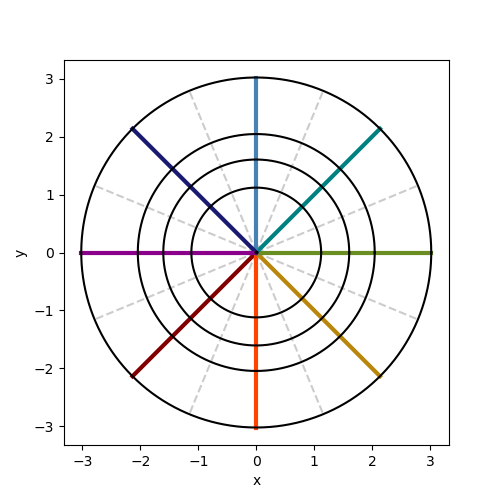

In [211]:
num_mag_bins_analyze=4
def plot_command_bin(): 
    bmi_b.plot_polar_bins(angle_bin_edges, mag_bin_edges[:,:(num_mag_bins_analyze)], target_color)
    
plt.figure(figsize=(5,5))
plot_command_bin()    

In [212]:
#Now replicate analysis: 
df_lqr = df_lqr_noise

#Calculate for each bin the average activity: 
#Then ... for each model, calc command_move_mean - move_mean. 
#to start, we ask if pooling already shows a difference.

#command mean: diff, ang, mag, model
df_mean_col = n_list + ['ba', 'bm', 'model', 'num']
nan_df = pd.DataFrame()
df_mean = []

sel_bin = df_lqr['bin']>=0
for ba in range(num_angle_bins):
    sel_ba = (df_lqr['u_v_angle_bin']==ba)
    for bm in range(num_mag_bins_analyze):
        sel_bm = (df_lqr['u_v_mag_bin']==bm)
        for m in model_list:
            sel_m = (df_lqr['model'] == m)
            
            
            sel = sel_ba&sel_bm&sel_m&sel_bin
            n_i = df_lqr.loc[sel,n_list].mean()
#             print(n_i.shape)
            
            
            df_i = pd.DataFrame(pd.DataFrame(np.ones((1,len(df_mean_col)))*np.nan, columns=df_mean_col))
            df_i.loc[0,n_list]=n_i
            df_i['ba'] = ba
            df_i['bm'] = bm
            df_i['model'] = m
            df_i['num'] = len(np.where(sel)[0])
            df_mean.append(df_i)
df_mean = pd.concat(df_mean, ignore_index=True)     

In [213]:
#mean diff: 
#ASSIGN: df_diff
df_diff_col = n_list + ['diff', 'ba', 'bm', 'model', 'target', 'task_rot', 'num']
nan_df = pd.DataFrame()
df_diff = []
sel_bin = df_lqr['bin']>=1
for ba in range(num_angle_bins):
    sel_ba = (df_lqr['u_v_angle_bin']==ba)
    sel_d_ba = (df_mean['ba'] == ba)    
    for bm in range(num_mag_bins_analyze):
        sel_bm = (df_lqr['u_v_mag_bin']==bm)
        sel_d_bm = (df_mean['bm'] == bm)
        for m in model_list:
            sel_m = (df_lqr['model'] == m)
            sel_d_m = (df_mean['model'] == m)
            sel_d = sel_d_ba&sel_d_bm&sel_d_m
            mean_i = df_mean.loc[sel_d, n_list]
            
            
            for task in task_rot_list:
                sel_task = (df_lqr['task_rot']==task)
                for target in range(num_targets):
                    sel_target = (df_lqr['target']==target)
                    
                    sel = sel_ba&sel_bm&sel_m&sel_task&sel_target&sel_bin
                    num = len(np.where(sel)[0])
                    if num > 0:
                        n_i = df_lqr.loc[sel,n_list].mean()
                        diff_i = n_i-mean_i
                        
                        df_i = pd.DataFrame(pd.DataFrame(np.ones((1,len(df_diff_col)))*np.nan, columns=df_diff_col))
                        df_i.loc[0,n_list]=n_i
                        df_i['diff']=np.linalg.norm(diff_i)
                        df_i['ba'] = ba
                        df_i['bm'] = bm
                        df_i['model'] = m
                        df_i['task_rot'] = task
                        df_i['target'] = target
                        df_i['num'] = num

                        df_diff.append(df_i)
df_diff = pd.concat(df_diff, ignore_index=True)   

In [214]:
df_lqr.shape

(56160, 74)

<IPython.core.display.Javascript object>


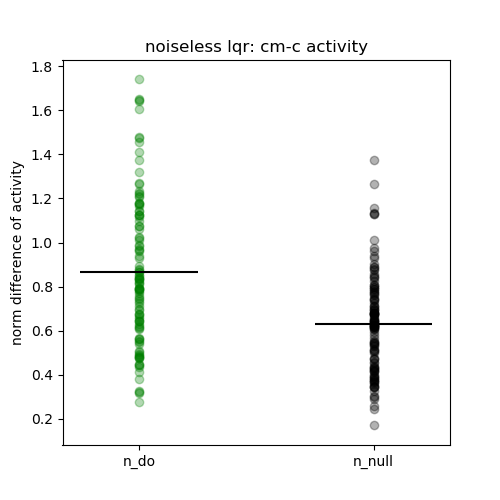

n_do
('n_do', 0.8651803169934544)
n_null
('n_null', 0.6315859690471366)
N noisy: 20


In [221]:
plt.figure(figsize=(5,5))

model_list = ['n_do', 'n_null']
model_color = {'n_do':'g', 'n_o':'r', 'n_null':'k'}
d_cm_diff = []

min_obs = 50
for i,m in enumerate(model_list):
    print(m)
    sel_m = df_diff['model']==m
    sel_obs = df_diff['num']>=min_obs
    
    sel = sel_m&sel_obs
    diff_i = df_diff.loc[sel, 'diff']
    d_cm_diff.append(diff_i)
    diff_mean_i = df_diff.loc[sel, 'diff'].mean()
    print(m, diff_mean_i)
    
    plt.scatter(i*np.ones(len(diff_i)), diff_i, alpha=0.3,color=model_color[m])
    plt.hlines(diff_mean_i, i-0.25,i+0.25)
    
_=plt.xticks([0,1], model_list)
plt.title('noiseless lqr: cm-c activity')
plt.ylabel('norm difference of activity')
print('N noisy: '+str(N_noisy))
    

<IPython.core.display.Javascript object>


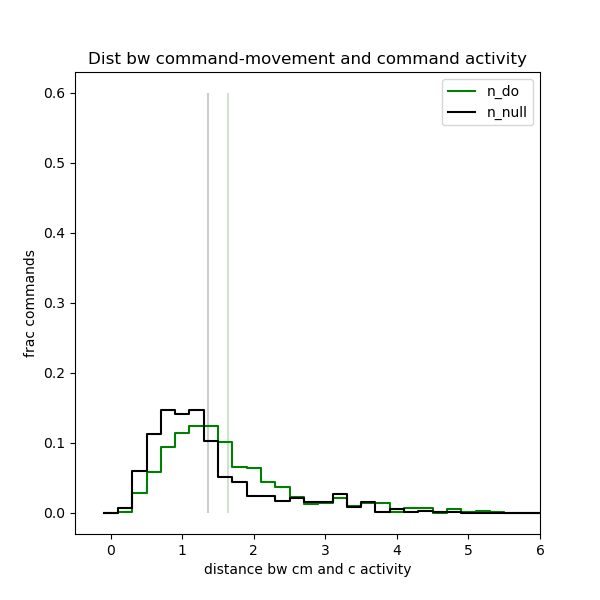

51
(104L,)
51
(104L,)


Text(0.5,1,'Dist bw command-movement and command activity')

In [216]:
#Histogram the diffs and plot overlapping distributions:
vmin = 0
vmax = 10
num_bins = (vmax-vmin)*5+1
cm_diff_bins_c = np.linspace(vmin,vmax,num_bins)
bin_w = cm_diff_bins_c[1]-cm_diff_bins_c[0]
cm_diff_bins_e = np.vstack((cm_diff_bins_c-bin_w/2, cm_diff_bins_c+bin_w/2))
bin_dic = {0:cm_diff_bins_e}

cm_diff_binned = []
for i,d in enumerate(d_cm_diff):
    d = np.array(d).reshape((-1,1))
    bin_result, hist_result = bmi_b.bin_vec_data(d,bin_dic)
    cm_diff_binned.append(hist_result)


model_color = {'n_do':'g', 'n_o':'r', 'n_null':'k'}    
cm_diff_bins_e_flat = np.hstack((cm_diff_bins_e[0,:], cm_diff_bins_e[1,-1]))

plt.figure(figsize=(6,6))
for i,d in enumerate(cm_diff_binned):
    m = model_list[i]
    d_plot = d/np.sum(d)
#     d_plot = np.cumsum(d_plot)
    bmi_util.hist_step_plot(cm_diff_bins_e_flat, d_plot,color=model_color[m],label=m)
    
    d_mean = np.mean(d_cm_diff[i])
    plt.vlines(d_mean, 0, 0.6, color=model_color[m],alpha=0.2)
plt.xlim((-0.5,6))    
plt.legend()    
plt.xlabel('distance bw cm and c activity')
plt.ylabel('frac commands')
plt.title('Dist bw command-movement and command activity')


### Replicate above using dataframes:

In [242]:
#Calculate for each bin the average activity: 
#Then ... for each model, calc command_move_mean - move_mean. 
#to start, we ask if pooling already shows a difference.

#command mean: diff, ang, mag, model
df_mean_col = n_list + ['ba', 'bm', 'model', 'num']
nan_df = pd.DataFrame()
df_mean = []

sel_bin = df_lqr['bin']>=0
for ba in range(num_angle_bins):
    sel_ba = (df_lqr['u_v_angle_bin']==ba)
    for bm in range(num_mag_bins_analyze):
        sel_bm = (df_lqr['u_v_mag_bin']==bm)
        for m in model_list:
            sel_m = (df_lqr['model'] == m)
            
            
            sel = sel_ba&sel_bm&sel_m&sel_bin
            n_i = df_lqr.loc[sel,n_list].mean()
#             print(n_i.shape)
            
            
            df_i = pd.DataFrame(pd.DataFrame(np.ones((1,len(df_mean_col)))*np.nan, columns=df_mean_col))
            df_i.loc[0,n_list]=n_i
            df_i['ba'] = ba
            df_i['bm'] = bm
            df_i['model'] = m
            df_i['num'] = len(np.where(sel)[0])
            df_mean.append(df_i)
df_mean = pd.concat(df_mean, ignore_index=True)        


In [243]:
#mean diff: 
#ASSIGN: df_diff
df_diff_col = n_list + ['diff', 'ba', 'bm', 'model', 'target', 'task_rot', 'num']
nan_df = pd.DataFrame()
df_diff = []
sel_bin = df_lqr['bin']>=1
for ba in range(num_angle_bins):
    sel_ba = (df_lqr['u_v_angle_bin']==ba)
    sel_d_ba = (df_mean['ba'] == ba)    
    for bm in range(num_mag_bins_analyze):
        sel_bm = (df_lqr['u_v_mag_bin']==bm)
        sel_d_bm = (df_mean['bm'] == bm)
        for m in model_list:
            sel_m = (df_lqr['model'] == m)
            sel_d_m = (df_mean['model'] == m)
            sel_d = sel_d_ba&sel_d_bm&sel_d_m
            mean_i = df_mean.loc[sel_d, n_list]
            
            
            for task in task_rot_list:
                sel_task = (df_lqr['task_rot']==task)
                for target in range(num_targets):
                    sel_target = (df_lqr['target']==target)
                    
                    sel = sel_ba&sel_bm&sel_m&sel_task&sel_target&sel_bin
                    num = len(np.where(sel)[0])
                    if num > 0:
                        n_i = df_lqr.loc[sel,n_list].mean()
                        diff_i = n_i-mean_i
                        
                        df_i = pd.DataFrame(pd.DataFrame(np.ones((1,len(df_diff_col)))*np.nan, columns=df_diff_col))
                        df_i.loc[0,n_list]=n_i
                        df_i['diff']=np.linalg.norm(diff_i)
                        df_i['ba'] = ba
                        df_i['bm'] = bm
                        df_i['model'] = m
                        df_i['task_rot'] = task
                        df_i['target'] = target
                        df_i['num'] = num

                        df_diff.append(df_i)
df_diff = pd.concat(df_diff, ignore_index=True)   

<IPython.core.display.Javascript object>


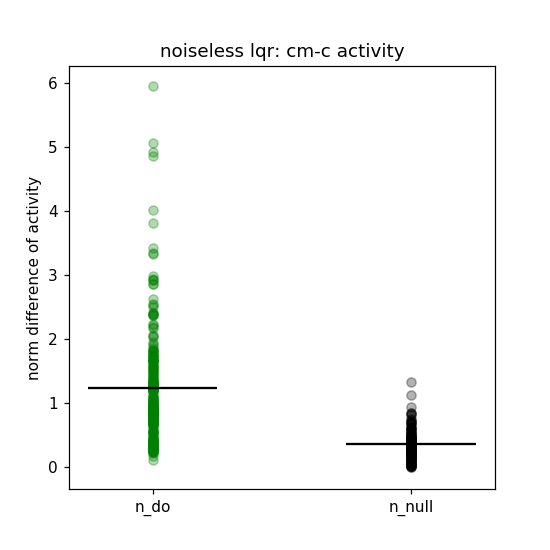

n_do
('n_do', 1.2362183096472699)
n_null
('n_null', 0.3554360736770427)


Text(0,0.5,'norm difference of activity')

In [295]:
plt.figure(figsize=(5,5))

model_list = ['n_do', 'n_null']
model_color = {'n_do':'g', 'n_o':'r', 'n_null':'k'}
d_cm_diff = []


for i,m in enumerate(model_list):
    print(m)
    sel_m = df_diff['model']==m
    
    sel = sel_m
    diff_i = df_diff.loc[sel, 'diff']
    d_cm_diff.append(diff_i)
    diff_mean_i = df_diff.loc[sel, 'diff'].mean()
    print(m, diff_mean_i)
    
    plt.scatter(i*np.ones(len(diff_i)), diff_i, alpha=0.3,color=model_color[m])
    plt.hlines(diff_mean_i, i-0.25,i+0.25)
    
_=plt.xticks([0,1], model_list)
plt.title('noiseless lqr: cm-c activity')
plt.ylabel('norm difference of activity')
    

### Replicate above results using arrays

In [205]:
cond_data[0]

('n_do', 0, 0, 0, 0)

In [246]:
m = 'n_do'
ba = 0
bm = 0
target = 0
task_rot = 0
cdata[m,ba,bm,target,task_rot,'mean']

array([ 1.29397856,  0.48548319,  0.21864989,  0.0978002 ,  1.32244111,
        2.44915543,  1.45936456,  0.23099744, -0.1977025 ,  0.12672003,
        0.05455178,  2.00997224,  0.04190412, -0.00474536,  1.10311516,
        1.88581243,  0.60013117,  0.71593982,  1.34082285,  0.6163296 ,
        0.55622055,  1.43685298,  1.50389978,  1.70103452,  0.34094094,
        0.55467544,  1.27751899,  1.66050618,  0.96522135,  0.74522552,
        1.29891908,  2.15252242,  1.44230336,  0.80174872,  0.39292278,
        1.09495542,  2.54171096,  2.02281937,  3.14541268,  1.33697917,
        1.37303491,  3.72581967,  0.9703143 ,  1.19258928])

In [240]:
cdata[m,ba,bm,target,task_rot].shape

(44L, 4L)

In [247]:
sel_m = (df_diff['model'] == m)
sel_ba = (df_diff['ba'] == ba)
sel_bm = (df_diff['bm'] == bm)
sel_task = (df_diff['task_rot'] == task_rot)
sel_target = (df_diff['target'] == target)

sel = sel_m&sel_ba&sel_bm&sel_task&sel_target

df_diff.loc[sel, :]


,n_0,n_1,n_2,n_3,n_4,n_5,n_6,n_7,n_8,n_9,...,n_41,n_42,n_43,diff,ba,bm,model,target,task_rot,num
0,1.293979,0.485483,0.21865,0.0978,1.322441,2.449155,1.459365,0.230997,-0.197703,0.12672,...,3.72582,0.970314,1.192589,0.798184,0,0,n_do,0,0.0,4


In [234]:
cond_data = []

cdata = {}
sel_bin = (df_lqr['bin']>=0) #

for ba in range(num_angle_bins): #[0]:
    sel_ba = (df_lqr['u_v_angle_bin']==ba) 
   
    for bm in range(num_mag_bins_analyze): #[0]:#
        sel_bm = (df_lqr['u_v_mag_bin']==bm)
        
        for m in model_list: # ['n_do']: #
            sel_m = (df_lqr['model'] == m)
            
            
            sel_c = sel_ba&sel_bm&sel_m&sel_bin
            d = np.array(df_lqr.loc[sel_c,n_list]).T
            cdata[m,ba,bm] = d
            cdata[m,ba,bm,'mean'] = np.mean(d, axis=1)
            
            for task_rot in task_rot_list: #[0]: #
                sel_task = (df_lqr['task_rot'] == task_rot)
                
                for target in range(num_targets): 
                    sel_target = (df_lqr['target'] == target)

                    sel = sel_ba\
                    &sel_bm\
                    &sel_m\
                    &sel_task\
                    &sel_target
                   # &sel_bin
                    
                    if sum(sel) > 0: 
                        cond_data.append((m, ba, bm, target, task_rot))
                        n_i = np.array(df_lqr.loc[sel,n_list]).T
                        
                        cdata[m,ba,bm,target,task_rot] = n_i
                        cdata[m,ba,bm,target,task_rot, 'mean'] = np.mean(n_i, axis=1)                        

In [235]:
#dataframe to store the results: 
df_diff_col = n_list + ['diff', 'diff_null', 'diff_potent', 'ba', 'bm', 'model', 'target', 'task_rot', 'num']
df_diff_noise = []
for ba in range(num_angle_bins):
    for bm in range(num_mag_bins_analyze):
        for m in model_list:
            c_mean = cdata[m,ba,bm,'mean']
            for task_rot in task_rot_list:
                for target in range(num_targets):
                    if (m, ba, bm, target, task_rot) in cond_data:
                        cm_mean = cdata[m,ba,bm,target,task_rot,'mean']
                        diff_i = cm_mean-c_mean
                        diff_potent_i, diff_null_i, _ = bmi_util.proj_null_potent(Kn[2:4,:].T, np.array(diff_i).reshape((-1,1)))

                        df_i = pd.DataFrame(pd.DataFrame(np.ones((1,len(df_diff_col)))*np.nan, columns=df_diff_col))
                        df_i.loc[0,n_list]=cm_mean
                        df_i['diff']=np.linalg.norm(diff_i)
                        df_i['diff_null']=np.linalg.norm(diff_null_i)
                        df_i['diff_potent']=np.linalg.norm(diff_potent_i)
                        df_i['ba'] = ba
                        df_i['bm'] = bm
                        df_i['model'] = m
                        df_i['task_rot'] = task
                        df_i['target'] = target
                        df_i['num'] = cdata[m,ba,bm,target,task_rot].shape[1]  

                        df_diff_noise.append(df_i)

df_diff_noise = pd.concat(df_diff_noise, ignore_index=True)

In [186]:
df_diff_noise.head()

,n_0,n_1,n_2,n_3,n_4,n_5,n_6,n_7,n_8,n_9,...,n_43,diff,diff_null,diff_potent,ba,bm,model,target,task_rot,num
0,1.293979,0.485483,0.218650,0.097800,1.322441,2.449155,1.459365,0.230997,-0.197703,0.126720,...,1.192589,0.798184,0.764105,0.230742,0,0,n_do,0,1.2,4
1,1.285892,0.472510,0.062755,0.043788,1.202707,2.290692,1.380854,0.246640,-0.023427,0.031299,...,1.227267,0.700910,0.520299,0.469643,0,0,n_do,1,1.2,1
2,1.331606,0.457789,0.324745,0.141595,1.215775,2.309637,1.395951,0.193936,-0.281676,0.162338,...,1.263866,1.287414,1.280246,0.135659,0,0,n_do,4,1.2,1
3,0.659791,0.321884,0.166645,0.100435,0.764419,1.792083,1.034863,0.226651,-0.001329,-0.013546,...,1.114827,4.019296,4.014935,0.187200,0,0,n_do,7,1.2,1
4,1.244780,0.456016,0.112553,0.065315,1.154455,2.212966,1.347837,0.230655,-0.047863,0.038339,...,1.240492,1.194439,1.087932,0.493041,0,0,n_do,0,1.2,1


<IPython.core.display.Javascript object>


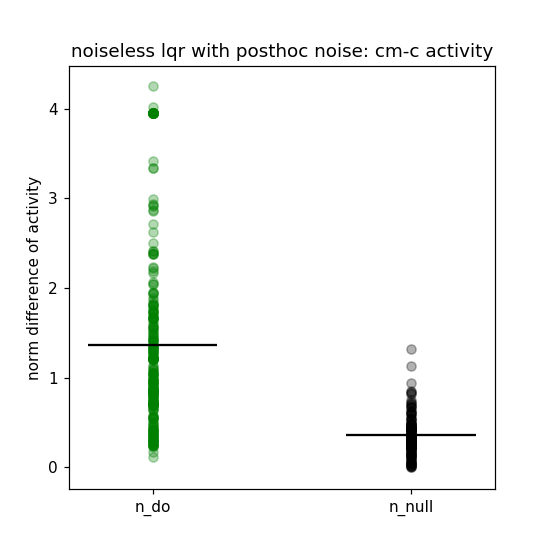

n_do
n_null


Text(0,0.5,'norm difference of activity')

In [237]:
plt.figure(figsize=(5,5))

model_list = ['n_do', 'n_null']
model_color = {'n_do':'g', 'n_o':'r', 'n_null':'k'}
d_cm_diff = []


for i,m in enumerate(model_list):
    print(m)
    sel_m = df_diff_noise['model']==m
    
    sel = sel_m
    diff_i = df_diff_noise.loc[sel, 'diff']
    d_cm_diff.append(diff_i)
    diff_mean_i = df_diff_noise.loc[sel, 'diff'].mean()
    
    plt.scatter(i*np.ones(len(diff_i)), diff_i, alpha=0.3,color=model_color[m])
    plt.hlines(diff_mean_i, i-0.25,i+0.25)
    
_=plt.xticks([0,1], model_list)
plt.title('noiseless lqr with posthoc noise: cm-c activity')
plt.ylabel('norm difference of activity')
    

<IPython.core.display.Javascript object>


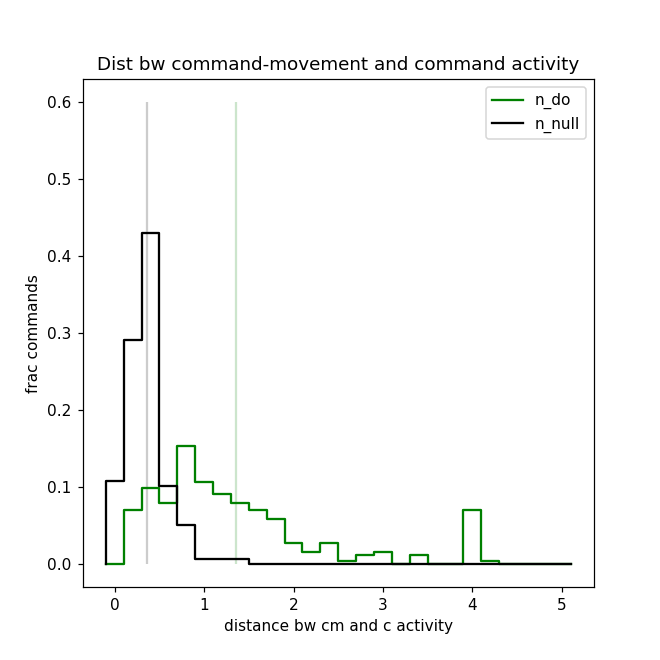

26
(54L,)
26
(54L,)


Text(0.5,1,'Dist bw command-movement and command activity')

In [248]:
#Histogram the diffs and plot overlapping distributions:
vmin = 0
vmax = 5
num_bins = (vmax-vmin)*5+1
cm_diff_bins_c = np.linspace(vmin,vmax,num_bins)
bin_w = cm_diff_bins_c[1]-cm_diff_bins_c[0]
cm_diff_bins_e = np.vstack((cm_diff_bins_c-bin_w/2, cm_diff_bins_c+bin_w/2))
bin_dic = {0:cm_diff_bins_e}

cm_diff_binned = []
for i,d in enumerate(d_cm_diff):
    d = np.array(d).reshape((-1,1))
    bin_result, hist_result = bmi_b.bin_vec_data(d,bin_dic)
    cm_diff_binned.append(hist_result)


model_color = {'n_do':'g', 'n_o':'r', 'n_null':'k'}    
cm_diff_bins_e_flat = np.hstack((cm_diff_bins_e[0,:], cm_diff_bins_e[1,-1]))

plt.figure(figsize=(6,6))
for i,d in enumerate(cm_diff_binned):
    m = model_list[i]
    d_plot = d/np.sum(d)
#     d_plot = np.cumsum(d_plot)
    bmi_util.hist_step_plot(cm_diff_bins_e_flat, d_plot,color=model_color[m],label=m)
    
    d_mean = np.mean(d_cm_diff[i])
    plt.vlines(d_mean, 0, 0.6, color=model_color[m],alpha=0.2)
# plt.xlim((-0.5,6))    
plt.legend()    
plt.xlabel('distance bw cm and c activity')
plt.ylabel('frac commands')
plt.title('Dist bw command-movement and command activity')


### Posthoc noise: 
add null space noise and then subselect the pool samples to match within command distribution
get a sense of how many noisy samples you need

Starting Questions: 

1) How many trials do I have now?  1 per movement.  (see trial column in df_lqr)

approach: 
if we only add null-space noise, the commands won't get matched... but we should still reproduce the noiseless effect by averaging.  

so let's start here.  

THEN, we simulate with null noise and replicate.  

THEN, we proceed to noise (not just null space noise)

--

we keep dictionary of arrays: 
(to execute more quickly than df)
command-movement
command - all qualified movements are equally represented. 

loop model
    loop command
        loop movement
            take the observations, add some amount of noise to each of them. 
            collect N of them into the general pool. 
            calculate the movement mean
        calculate the command mean
    

In [ ]:
#COMPUTE NOISE TO ADD: 

In [22]:
#Compute projection P into decoder
Kn2v = Kn[2:4,:]
u,s,vh = np.linalg.svd(Kn2v)
vh_trunc = vh[:2,:]
P = np.dot(vh_trunc.T,vh_trunc)
P.shape
# np.linalg.matrix_rank(P)
# test = np.dot(u, np.dot(np.diag(s), vh_trunc))

2

<IPython.core.display.Javascript object>


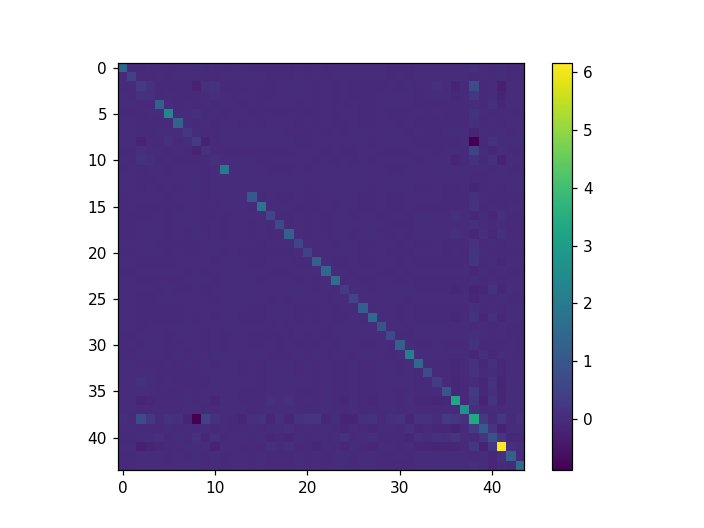

<IPython.core.display.Javascript object>


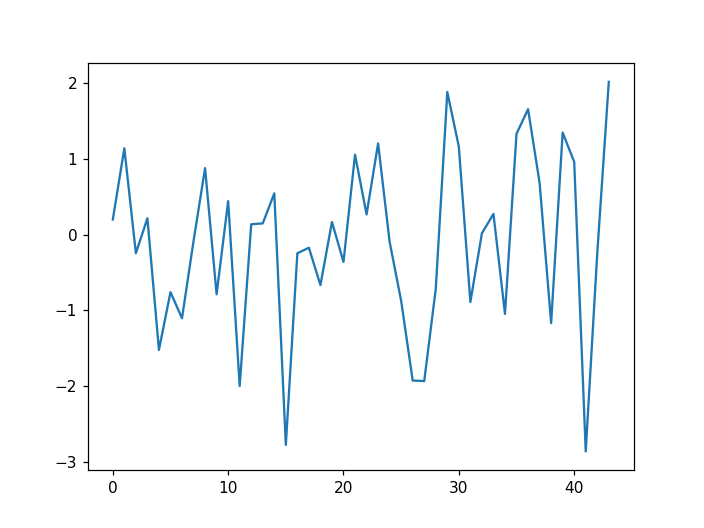

In [284]:
#Compute noise to add: 

sel_t_bin = (df['bin'] >= 0)
sel_t_bin_end = (df['bin_end'] >= 1)
sel_t = (sel_t_bin)&(sel_t_bin_end)
n_t = df.loc[sel_t,n_list]

sel_tp1_bin = (df['bin'] >= 1)
sel_tp1_bin_end = (df['bin_end'] >= 0)
sel_tp1 = (sel_tp1_bin)&(sel_tp1_bin_end)
n_tp1 = df.loc[sel_tp1,n_list]

n_t_m = np.mat(n_t).T
n_tp1_m = np.mat(n_tp1).T
An_m = np.mat(An)
bn_m = np.mat(bn).T
nhat_tp1 = An_m*n_t_m+bn_m

res_hat = nhat_tp1-n_tp1_m #44 x num_obs
res_cov = np.cov(res_hat) #44 x 44
res_cov_d = np.diag(np.diag(res_cov))

#Zero out the noise in the potent dimensions of the decoder: 
# res_cov_d_NULL = res_cov_d-np.dot(np.dot(P,res_cov_d), P.T)
P_null = np.eye(num_neurons)-P
res_cov_d_NULL = np.dot(np.dot(P_null,res_cov_d), P_null.T)

state_noise_mean = np.zeros(num_neurons)
state_noise_cov = res_cov_d_NULL #res_cov_d
state_noise = np.random.multivariate_normal(mean=state_noise_mean, cov=state_noise_cov)

plt.figure()
plt.imshow(state_noise_cov)
plt.colorbar()

plt.figure()
plt.plot(state_noise)

# #simulate with noise: 
# #Define a noise covariance, and let's just simulate one trial to start with:
# state_dim = num_neurons+len(kin_var)+len(offset_var)
# state_noise_mean = np.zeros(state_dim)
# state_noise_cov = np.zeros((state_dim, state_dim)) #np.eye(state_dim)*0.5
# state_noise_cov[:num_neurons,:num_neurons] = res_cov_d
# state_noise_cov[num_neurons:, num_neurons:] = 0

# plt.figure(figsize=(5,5))
# plt.imshow(state_noise_cov)

# #Test noise generation:
# state_noise = np.random.multivariate_normal(mean=state_noise_mean, cov=state_noise_cov)
# state_noise.shape
# state_noise

# # plt.figure()
# # plt.plot(state_noise, '.-')

In [305]:
#ADD NULL NOISE TO THE MEASUREMENTS

#Total number of samples per command,movement,model: 
N_noisy = 100 #1000

cond_data = []

cdata = {}
for ba in range(num_angle_bins):
    sel_ba = (df_lqr['u_v_angle_bin']==ba) 
   
    for bm in range(num_mag_bins_analyze):
        sel_bm = (df_lqr['u_v_mag_bin']==bm)
        
        for m in model_list:
            sel_m = (df_lqr['model'] == m)
            cdata[m,ba,bm] = []
            
            for task_rot in task_rot_list:
                sel_task = (df_lqr['task_rot'] == task_rot)
                
                for target in range(num_targets):
                    sel_target = (df_lqr['target'] == target)

                    sel = sel_ba\
                    &sel_bm\
                    &sel_m\
                    &sel_task\
                    &sel_target
                    if sum(sel) > 0: 
                        cond_data.append((m, ba, bm, target, task_rot))
                        n_i = np.array(df_lqr.loc[sel,n_list]).T
#                         noisy_data = n_i # for debugging
                        num_noise_per_sample = int(np.ceil(N_noisy/n_i.shape[1]))
                        noisy_data = []
                        for obs in n_i.T:
                            noise = np.random.multivariate_normal(mean=state_noise_mean, cov=state_noise_cov, size=(num_noise_per_sample))
                            noisy_obs = noise+obs[None,:]
                            noisy_data.append(noisy_obs)
                        noisy_data = np.concatenate(noisy_data,axis=0).T

                        cdata[m,ba,bm,target,task_rot] = noisy_data
                        cdata[m,ba,bm,target,task_rot, 'mean'] = np.mean(noisy_data, axis=1)
                        
                        cdata[m,ba,bm].append(noisy_data)       
            cdata[m,ba,bm] = np.concatenate(cdata[m,ba,bm],axis=1)
            cdata[m,ba,bm, 'mean'] = np.mean(cdata[m,ba,bm], axis=1)
                        

In [306]:
#dataframe to store the results: 
df_diff_col = n_list + ['diff', 'diff_null', 'diff_potent', 'ba', 'bm', 'model', 'target', 'task_rot', 'num']
df_diff_noise = []
for ba in range(num_angle_bins):
    for bm in range(num_mag_bins_analyze):
        for m in model_list:
            c_mean = cdata[m,ba,bm,'mean']
            for task_rot in task_rot_list:
                for target in range(num_targets):
                    if (m, ba, bm, target, task_rot) in cond_data:
                        cm_mean = cdata[m,ba,bm,target,task_rot,'mean']
                        diff_i = cm_mean-c_mean
                        diff_potent_i, diff_null_i, _ = bmi_util.proj_null_potent(Kn[2:4,:].T, np.array(diff_i).reshape((-1,1)))


                        np.linalg.norm(c_mean-cm_mean)


                        df_i = pd.DataFrame(pd.DataFrame(np.ones((1,len(df_diff_col)))*np.nan, columns=df_diff_col))
                        df_i.loc[0,n_list]=cm_mean
                        df_i['diff']=np.linalg.norm(diff_i)
                        df_i['diff_null']=np.linalg.norm(diff_null_i)
                        df_i['diff_potent']=np.linalg.norm(diff_potent_i)
                        df_i['ba'] = ba
                        df_i['bm'] = bm
                        df_i['model'] = m
                        df_i['task_rot'] = task
                        df_i['target'] = target
                        df_i['num'] = num  

                        df_diff_noise.append(df_i)

df_diff_noise = pd.concat(df_diff_noise, ignore_index=True)

<IPython.core.display.Javascript object>


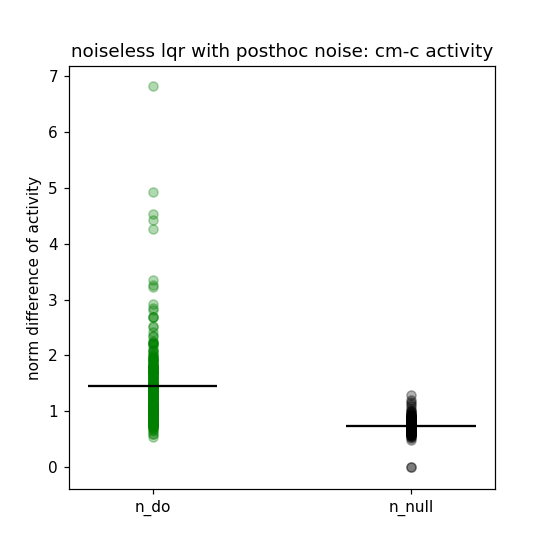

n_do
('n_do', 1.4572555705479755)
n_null
('n_null', 0.7452937875425383)


Text(0,0.5,'norm difference of activity')

In [307]:
plt.figure(figsize=(5,5))

model_list = ['n_do', 'n_null']
model_color = {'n_do':'g', 'n_o':'r', 'n_null':'k'}
d_cm_diff = []


for i,m in enumerate(model_list):
    print(m)
    sel_m = df_diff_noise['model']==m
    
    sel = sel_m
    diff_i = df_diff_noise.loc[sel, 'diff']
    d_cm_diff.append(diff_i)
    diff_mean_i = df_diff_noise.loc[sel, 'diff'].mean()
    print(m, diff_mean_i)
    
    plt.scatter(i*np.ones(len(diff_i)), diff_i, alpha=0.3,color=model_color[m])
    plt.hlines(diff_mean_i, i-0.25,i+0.25)
    
_=plt.xticks([0,1], model_list)
plt.title('noiseless lqr with posthoc noise: cm-c activity')
plt.ylabel('norm difference of activity')
    

<IPython.core.display.Javascript object>


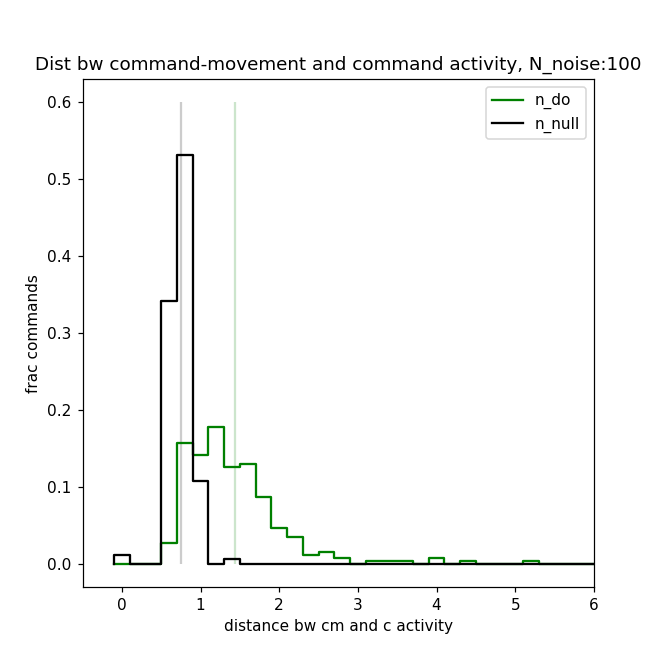

36
(74L,)
36
(74L,)


Text(0.5,1,'Dist bw command-movement and command activity, N_noise:100')

In [304]:
#Histogram the diffs and plot overlapping distributions:
vmin = 0
vmax = 7
num_bins = (vmax-vmin)*5+1
cm_diff_bins_c = np.linspace(vmin,vmax,num_bins)

bin_w = cm_diff_bins_c[1]-cm_diff_bins_c[0]
cm_diff_bins_e = np.vstack((cm_diff_bins_c-bin_w/2, cm_diff_bins_c+bin_w/2))
bin_dic = {0:cm_diff_bins_e}

cm_diff_binned = []
for i,d in enumerate(d_cm_diff):
    d = np.array(d).reshape((-1,1))
    bin_result, hist_result = bmi_b.bin_vec_data(d,bin_dic)
    cm_diff_binned.append(hist_result)


model_color = {'n_do':'g', 'n_o':'r', 'n_null':'k'}    
cm_diff_bins_e_flat = np.hstack((cm_diff_bins_e[0,:], cm_diff_bins_e[1,-1]))

plt.figure(figsize=(6,6))
for i,d in enumerate(cm_diff_binned):
    m = model_list[i]
    d_plot = d/np.sum(d)
#     d_plot = np.cumsum(d_plot)
    bmi_util.hist_step_plot(cm_diff_bins_e_flat, d_plot,color=model_color[m],label=m)
    
    d_mean = np.mean(d_cm_diff[i])
    plt.vlines(d_mean, 0, 0.6, color=model_color[m],alpha=0.2)
plt.xlim((-0.5,6))    
plt.legend()    
plt.xlabel('distance bw cm and c activity')
plt.ylabel('frac commands')
plt.title('Dist bw command-movement and command activity, N_noise:'+str(N_noisy))


### Confirm within bin difference

In [114]:
#Let's loop and confirm there's no within bin difference: 
#loop each command (get command distribution)
#loop each movement (get cm distribution)
#use t-test to compare x and y distribution

model_list = ['n_do', 'n_null']
df_t_col = ['diff_x', 'diff_y', 'xstat', 'xp', 'ystat', 'yp', 'ba', 'bm', 'model', 'task_rot', 'target', 'num_cm', 'num_c']
df_t = []
for ba in range(num_angle_bins):
    sel_ba = (df_lqr['u_v_angle_bin']==ba)
    for bm in range(num_mag_bins_analyze):
        sel_bm = (df_lqr['u_v_mag_bin']==bm)
        for m in model_list:
            sel_m = (df_lqr['model'] == m)
            sel_c = sel_ba&sel_bm&sel_m
            cx = df_lqr.loc[sel_c, 'u_vx'] 
            cy = df_lqr.loc[sel_c, 'u_vy'] 
            num_c = len(np.where(sel_c)[0])
            
            for task in task_rot_list:
                sel_task = (df_lqr['task_rot']==task)
                for target in range(num_targets):
                    sel_target = (df_lqr['target']==target)
                    sel_cm = sel_ba&sel_bm&sel_m&sel_task&sel_target
                    cmx = df_lqr.loc[sel_cm, 'u_vx'] 
                    cmy = df_lqr.loc[sel_cm, 'u_vy']                     
                    
                    num_cm = len(np.where(sel_cm)[0])
                    if num_cm > 0:
                        print(ba, bm, m, task, target)
                        xstat, xp = sio_stat.ttest_ind(cx, cmx)
                        ystat, yp = sio_stat.ttest_ind(cy, cmy)
                        
                        df_i = pd.DataFrame(pd.DataFrame(np.ones((1,len(df_t_col)))*np.nan, columns=df_t_col))
                        df_i['diff_x']=cx.mean()-cmx.mean()
                        df_i['diff_y']=cy.mean()-cmy.mean()
                        df_i['xstat'] = xstat
                        df_i['xp'] = xp
                        df_i['ystat'] = ystat
                        df_i['yp'] = yp
                        
                        df_i['ba'] = ba
                        df_i['bm'] = bm
                        df_i['model'] = m
                        df_i['task_rot'] = task
                        df_i['target'] = target
                        df_i['num_cm'] = num_cm
                        df_i['num_c'] = num_c

                        df_t.append(df_i)
df_t = pd.concat(df_t, ignore_index=True)              

(0, 0, 'n_do', 0, 0)
(0, 0, 'n_do', 0, 1)
(0, 0, 'n_do', 0, 2)
(0, 0, 'n_do', 0, 3)
(0, 0, 'n_do', 0, 4)
(0, 0, 'n_do', 0, 5)
(0, 0, 'n_do', 0, 6)
(0, 0, 'n_do', 0, 7)
(0, 0, 'n_do', 1.1, 0)
(0, 0, 'n_do', 1.1, 1)
(0, 0, 'n_do', 1.1, 2)
(0, 0, 'n_do', 1.1, 3)
(0, 0, 'n_do', 1.1, 4)
(0, 0, 'n_do', 1.1, 5)
(0, 0, 'n_do', 1.1, 6)
(0, 0, 'n_do', 1.1, 7)
(0, 0, 'n_do', 1.2, 0)
(0, 0, 'n_do', 1.2, 1)
(0, 0, 'n_do', 1.2, 2)
(0, 0, 'n_do', 1.2, 3)
(0, 0, 'n_do', 1.2, 4)
(0, 0, 'n_do', 1.2, 5)
(0, 0, 'n_do', 1.2, 6)
(0, 0, 'n_do', 1.2, 7)
(0, 0, 'n_null', 0, 0)
(0, 0, 'n_null', 0, 1)
(0, 0, 'n_null', 0, 2)
(0, 0, 'n_null', 0, 3)
(0, 0, 'n_null', 0, 4)
(0, 0, 'n_null', 0, 5)
(0, 0, 'n_null', 0, 6)
(0, 0, 'n_null', 0, 7)
(0, 0, 'n_null', 1.1, 0)
(0, 0, 'n_null', 1.1, 1)
(0, 0, 'n_null', 1.1, 2)
(0, 0, 'n_null', 1.1, 3)
(0, 0, 'n_null', 1.1, 4)
(0, 0, 'n_null', 1.1, 5)
(0, 0, 'n_null', 1.1, 6)
(0, 0, 'n_null', 1.1, 7)
(0, 0, 'n_null', 1.2, 0)
(0, 0, 'n_null', 1.2, 1)
(0, 0, 'n_null', 1.2, 2)
(0, 0

(1, 3, 'n_do', 1.2, 6)
(1, 3, 'n_do', 1.2, 7)
(1, 3, 'n_null', 0, 0)
(1, 3, 'n_null', 0, 1)
(1, 3, 'n_null', 0, 2)
(1, 3, 'n_null', 0, 3)
(1, 3, 'n_null', 0, 4)
(1, 3, 'n_null', 0, 5)
(1, 3, 'n_null', 0, 6)
(1, 3, 'n_null', 0, 7)
(1, 3, 'n_null', 1.1, 0)
(1, 3, 'n_null', 1.1, 1)
(1, 3, 'n_null', 1.1, 2)
(1, 3, 'n_null', 1.1, 3)
(1, 3, 'n_null', 1.1, 4)
(1, 3, 'n_null', 1.1, 5)
(1, 3, 'n_null', 1.1, 6)
(1, 3, 'n_null', 1.1, 7)
(1, 3, 'n_null', 1.2, 0)
(1, 3, 'n_null', 1.2, 1)
(1, 3, 'n_null', 1.2, 2)
(1, 3, 'n_null', 1.2, 3)
(1, 3, 'n_null', 1.2, 4)
(1, 3, 'n_null', 1.2, 5)
(1, 3, 'n_null', 1.2, 6)
(1, 3, 'n_null', 1.2, 7)
(2, 0, 'n_do', 0, 0)
(2, 0, 'n_do', 0, 1)
(2, 0, 'n_do', 0, 2)
(2, 0, 'n_do', 0, 3)
(2, 0, 'n_do', 0, 4)
(2, 0, 'n_do', 0, 5)
(2, 0, 'n_do', 0, 6)
(2, 0, 'n_do', 0, 7)
(2, 0, 'n_do', 1.1, 0)
(2, 0, 'n_do', 1.1, 1)
(2, 0, 'n_do', 1.1, 2)
(2, 0, 'n_do', 1.1, 3)
(2, 0, 'n_do', 1.1, 4)
(2, 0, 'n_do', 1.1, 5)
(2, 0, 'n_do', 1.1, 6)
(2, 0, 'n_do', 1.1, 7)
(2, 0, 'n_do', 1.2

(3, 2, 'n_null', 1.2, 2)
(3, 2, 'n_null', 1.2, 3)
(3, 2, 'n_null', 1.2, 4)
(3, 2, 'n_null', 1.2, 5)
(3, 2, 'n_null', 1.2, 6)
(3, 2, 'n_null', 1.2, 7)
(3, 3, 'n_do', 0, 0)
(3, 3, 'n_do', 0, 1)
(3, 3, 'n_do', 0, 2)
(3, 3, 'n_do', 0, 3)
(3, 3, 'n_do', 0, 4)
(3, 3, 'n_do', 0, 5)
(3, 3, 'n_do', 0, 6)
(3, 3, 'n_do', 0, 7)
(3, 3, 'n_do', 1.1, 0)
(3, 3, 'n_do', 1.1, 1)
(3, 3, 'n_do', 1.1, 2)
(3, 3, 'n_do', 1.1, 3)
(3, 3, 'n_do', 1.1, 4)
(3, 3, 'n_do', 1.1, 5)
(3, 3, 'n_do', 1.1, 6)
(3, 3, 'n_do', 1.1, 7)
(3, 3, 'n_do', 1.2, 0)
(3, 3, 'n_do', 1.2, 1)
(3, 3, 'n_do', 1.2, 2)
(3, 3, 'n_do', 1.2, 3)
(3, 3, 'n_do', 1.2, 4)
(3, 3, 'n_do', 1.2, 5)
(3, 3, 'n_do', 1.2, 6)
(3, 3, 'n_do', 1.2, 7)
(3, 3, 'n_null', 0, 0)
(3, 3, 'n_null', 0, 1)
(3, 3, 'n_null', 0, 2)
(3, 3, 'n_null', 0, 3)
(3, 3, 'n_null', 0, 4)
(3, 3, 'n_null', 0, 5)
(3, 3, 'n_null', 0, 6)
(3, 3, 'n_null', 0, 7)
(3, 3, 'n_null', 1.1, 0)
(3, 3, 'n_null', 1.1, 1)
(3, 3, 'n_null', 1.1, 2)
(3, 3, 'n_null', 1.1, 3)
(3, 3, 'n_null', 1.1, 4)
(3, 3

(5, 2, 'n_do', 1.2, 0)
(5, 2, 'n_do', 1.2, 1)
(5, 2, 'n_do', 1.2, 2)
(5, 2, 'n_do', 1.2, 3)
(5, 2, 'n_do', 1.2, 4)
(5, 2, 'n_do', 1.2, 5)
(5, 2, 'n_do', 1.2, 6)
(5, 2, 'n_do', 1.2, 7)
(5, 2, 'n_null', 0, 0)
(5, 2, 'n_null', 0, 1)
(5, 2, 'n_null', 0, 2)
(5, 2, 'n_null', 0, 3)
(5, 2, 'n_null', 0, 4)
(5, 2, 'n_null', 0, 5)
(5, 2, 'n_null', 0, 6)
(5, 2, 'n_null', 0, 7)
(5, 2, 'n_null', 1.1, 0)
(5, 2, 'n_null', 1.1, 1)
(5, 2, 'n_null', 1.1, 2)
(5, 2, 'n_null', 1.1, 3)
(5, 2, 'n_null', 1.1, 4)
(5, 2, 'n_null', 1.1, 5)
(5, 2, 'n_null', 1.1, 6)
(5, 2, 'n_null', 1.1, 7)
(5, 2, 'n_null', 1.2, 0)
(5, 2, 'n_null', 1.2, 1)
(5, 2, 'n_null', 1.2, 2)
(5, 2, 'n_null', 1.2, 3)
(5, 2, 'n_null', 1.2, 4)
(5, 2, 'n_null', 1.2, 5)
(5, 2, 'n_null', 1.2, 6)
(5, 2, 'n_null', 1.2, 7)
(5, 3, 'n_do', 0, 0)
(5, 3, 'n_do', 0, 1)
(5, 3, 'n_do', 0, 2)
(5, 3, 'n_do', 0, 3)
(5, 3, 'n_do', 0, 4)
(5, 3, 'n_do', 0, 5)
(5, 3, 'n_do', 0, 6)
(5, 3, 'n_do', 0, 7)
(5, 3, 'n_do', 1.1, 0)
(5, 3, 'n_do', 1.1, 1)
(5, 3, 'n_do', 1.1

(7, 1, 'n_null', 1.1, 2)
(7, 1, 'n_null', 1.1, 3)
(7, 1, 'n_null', 1.1, 4)
(7, 1, 'n_null', 1.1, 5)
(7, 1, 'n_null', 1.1, 6)
(7, 1, 'n_null', 1.1, 7)
(7, 1, 'n_null', 1.2, 0)
(7, 1, 'n_null', 1.2, 1)
(7, 1, 'n_null', 1.2, 2)
(7, 1, 'n_null', 1.2, 3)
(7, 1, 'n_null', 1.2, 4)
(7, 1, 'n_null', 1.2, 5)
(7, 1, 'n_null', 1.2, 6)
(7, 1, 'n_null', 1.2, 7)
(7, 2, 'n_do', 0, 0)
(7, 2, 'n_do', 0, 1)
(7, 2, 'n_do', 0, 2)
(7, 2, 'n_do', 0, 3)
(7, 2, 'n_do', 0, 4)
(7, 2, 'n_do', 0, 5)
(7, 2, 'n_do', 0, 6)
(7, 2, 'n_do', 0, 7)
(7, 2, 'n_do', 1.1, 0)
(7, 2, 'n_do', 1.1, 1)
(7, 2, 'n_do', 1.1, 2)
(7, 2, 'n_do', 1.1, 3)
(7, 2, 'n_do', 1.1, 4)
(7, 2, 'n_do', 1.1, 5)
(7, 2, 'n_do', 1.1, 6)
(7, 2, 'n_do', 1.1, 7)
(7, 2, 'n_do', 1.2, 0)
(7, 2, 'n_do', 1.2, 1)
(7, 2, 'n_do', 1.2, 2)
(7, 2, 'n_do', 1.2, 3)
(7, 2, 'n_do', 1.2, 4)
(7, 2, 'n_do', 1.2, 5)
(7, 2, 'n_do', 1.2, 6)
(7, 2, 'n_do', 1.2, 7)
(7, 2, 'n_null', 0, 0)
(7, 2, 'n_null', 0, 1)
(7, 2, 'n_null', 0, 2)
(7, 2, 'n_null', 0, 3)
(7, 2, 'n_null', 0, 4)

In [115]:
df_t

,diff_x,diff_y,xstat,xp,ystat,yp,ba,bm,model,task_rot,target,num_cm,num_c
0,0.054174,0.030060,12.513861,7.821203e-36,6.901342,5.261130e-12,0,0,n_do,0.0,0,3192,24793
1,-0.015053,0.022107,-3.541329,3.987607e-04,5.108250,3.272800e-07,0,0,n_do,0.0,1,3303,24793
2,-0.085401,-0.032850,-13.510724,1.861746e-41,-5.119367,3.087307e-07,0,0,n_do,0.0,2,1401,24793
3,-0.108708,-0.069845,-11.062460,2.215774e-28,-7.034886,2.044889e-12,0,0,n_do,0.0,3,565,24793
4,-0.123412,-0.095584,-12.152157,6.943963e-34,-9.324888,1.198964e-20,0,0,n_do,0.0,4,528,24793
5,-0.090471,-0.108404,-10.456118,1.547086e-25,-12.429733,2.281764e-35,0,0,n_do,0.0,5,734,24793
6,-0.024004,-0.060763,-3.686675,2.276629e-04,-9.284090,1.753730e-20,0,0,n_do,0.0,6,1331,24793
7,0.064774,0.004882,12.206805,3.522603e-34,0.919786,3.576927e-01,0,0,n_do,0.0,7,2058,24793
8,-0.006691,-0.004240,-0.859071,3.903091e-01,-0.540034,5.891786e-01,0,0,n_do,1.1,0,912,24793
9,0.031887,0.014011,3.915457,9.046680e-05,1.707828,8.768031e-02,0,0,n_do,1.1,1,833,24793


In [ ]:
#Visualize some command distributions: 


In [ ]:
#mean diff: 
df_diff_col = n_list + ['diff', 'ba', 'bm', 'model', 'target', 'task_rot', 'num']
nan_df = pd.DataFrame()
df_diff = []
for ba in range(num_angle_bins):
    sel_ba = (df_lqr['u_v_angle_bin']==ba)
    sel_d_ba = (df_mean['ba'] == ba)    
    for bm in range(num_mag_bins_analyze):
        sel_bm = (df_lqr['u_v_mag_bin']==bm)
        sel_d_bm = (df_mean['bm'] == bm)
        for m in model_list:
            sel_m = (df_lqr['model'] == m)
            sel_d_m = (df_mean['model'] == m)
            sel_d = sel_d_ba&sel_d_bm&sel_d_m
            mean_i = df_mean.loc[sel_d, n_list]
            
            
            for task in task_rot_list:
                sel_task = (df_lqr['task_rot']==task)
                for target in range(num_targets):
                    sel_target = (df_lqr['target']==target)
                    
                    sel = sel_ba&sel_bm&sel_m&sel_task&sel_target
                    num = len(np.where(sel)[0])
                    if num > 0:
                        n_i = df_lqr.loc[sel,n_list].mean()
                        diff_i = n_i-mean_i
                        
                        df_i = pd.DataFrame(pd.DataFrame(np.ones((1,len(df_diff_col)))*np.nan, columns=df_diff_col))
                        df_i.loc[0,n_list]=n_i
                        df_i['diff']=np.linalg.norm(diff_i)
                        df_i['ba'] = ba
                        df_i['bm'] = bm
                        df_i['model'] = m
                        df_i['task_rot'] = task
                        df_i['target'] = target
                        df_i['num'] = num

                        df_diff.append(df_i)
df_diff = pd.concat(df_diff, ignore_index=True)   